# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import skimage
import os
import glob
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import egg_class_functions as ecf
from napari_convpaint.conv_paint_model import ConvpaintModel
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, erosion, dilation, footprint_rectangle, remove_small_holes
from skimage.util import img_as_ubyte
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from joblib import load, dump

importlib.reload(ecf)

# Variable setup

In [ ]:
seg_model = ConvpaintModel(model_path="Models/Enet_v7.pkl")
seg_class_model = load("Models/complete_segmentation_identifier_random_forest.joblib")

image_paths = sorted(glob.glob("Data/raw/*/**/*.*", recursive=True), key=lambda x: (os.path.dirname(x), os.path.basename(x)))
height = 2076
width = 3088


# picture import and segmentation

In [17]:
images, df = ecf.egg_image_data_import(image_paths)

In [18]:
resize_mask = []
for i, image in enumerate(images):
    if image.shape[:2] != (height, width):
        image, content_mask = ecf.resize_with_padding(image, width, height)
        images[i] = image
    else:
        content_mask = np.ones((height, width), dtype=bool)
    resize_mask.append(content_mask)

In [19]:
data = []
for i, image in enumerate(images):
    segment_mask = ecf.segmentation(image, seg_model)
    if image.shape[:2] != (height, width):
        segment_mask[~resize_mask[i]] = 1
    regions, labeled_overlay = ecf.region_sepperation(segment_mask)
    for j, region in enumerate(regions):
        masked_image, mask, parameters = ecf.region_processing(image, labeled_overlay, region)
        df_info = df.iloc[i].to_dict()
        combined = {**df_info, 'image_index': i, 'region_index': j, **parameters}
        data.append(combined)
        skimage.io.imsave(f"Data/processed/segment_images/image_{i}_segment_{j}.png", img_as_ubyte(masked_image))
        skimage.io.imsave(f"Data/processed/segment_masks/image_{i}_mask_{j}.png", img_as_ubyte(mask))
data_df = pd.DataFrame(data)
data_df.to_csv("Data/processed/segmentation_data.csv")

# Segment Classification

In [40]:
import json
with open('labels.json', 'r', encoding='utf-8') as file:
    labels = json.load(file)
data_df['json_key'] = data_df.apply(ecf.make_key, axis=1)

data_df['label'] = data_df['json_key'].map(labels)

# One-Hot-Encoding der 'label'-Spalte
label_ohe = pd.get_dummies(data_df['label'], prefix='label').astype(int)


# Die neuen Spalten an den DataFrame anh�ngen
data_df = pd.concat([data_df, label_ohe], axis=1)

# Optional: Hilfsspalten entfernen
data_df.drop(columns=['json_key', 'label'], inplace=True)


data_df

,path,category,species,image_index,region_index,angle,area,perimeter,roundness,length,width,len_wid_ratio,laplacian,edge,label_cut-off,label_multi,label_single
0,Data/raw/aegypti_old/ag_01.tif,raw,aegypti_old,0,0,1.216675,72422.0,1606.489465,0.352634,414.047976,281.976650,1.468377,0.005848,0.016318,1,0,0
1,Data/raw/aegypti_old/ag_01.tif,raw,aegypti_old,0,1,1.484426,70991.0,1344.014285,0.493862,565.265789,161.201074,3.506588,0.010621,0.050064,0,0,1
2,Data/raw/aegypti_old/ag_01.tif,raw,aegypti_old,0,2,1.305724,50188.0,1181.068109,0.452126,511.529870,126.148699,4.054975,0.010533,0.039691,0,0,1
3,Data/raw/aegypti_old/ag_01.tif,raw,aegypti_old,0,3,0.343938,886890.0,13025.743284,0.065686,1758.612211,1058.127481,1.662004,0.004566,0.017573,0,1,0
4,Data/raw/aegypti_old/ag_01.tif,raw,aegypti_old,0,4,-0.741559,63642.0,1273.477272,0.493141,449.718013,189.555912,2.372482,0.008519,0.025794,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,Data/raw/albopictus_old/ap_20.tif,raw,albopictus_old,39,2,-0.613039,40162.0,1007.844805,0.496864,422.232885,122.958675,3.433941,0.004890,0.017188,0,0,1
304,Data/raw/albopictus_old/ap_20.tif,raw,albopictus_old,39,3,-1.410571,40011.0,1030.742207,0.473248,438.018380,117.173863,3.738192,0.006009,0.020151,1,0,0
305,Data/raw/albopictus_old/ap_20.tif,raw,albopictus_old,39,4,-0.554462,41968.0,1206.673232,0.362200,508.054508,108.127607,4.698657,0.004037,0.013882,1,0,0
306,Data/raw/albopictus_old/ap_20.tif,raw,albopictus_old,39,5,-0.327147,98802.0,1602.832611,0.483280,456.916309,296.177457,1.542711,0.006398,0.031400,0,1,0


In [ ]:
X = data_df.iloc[:, 6:14]
y = data_df.iloc[:, 14:]

In [21]:
y_pred = seg_class_model.predict(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell erstellen und trainieren
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Vorhersage
y_pred = model.predict(X_test)

In [ ]:
param_grid = {
    "n_estimators": [10, 50, 100, 200, 500],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

grid_search_forest = GridSearchCV(model, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=2)
grid_search_forest.fit(X, y)
best_forest_model = grid_search_forest.best_estimator_
y_pred = best_forest_model.predict(X_test)

In [52]:
y_pred = best_forest_model.predict(X)

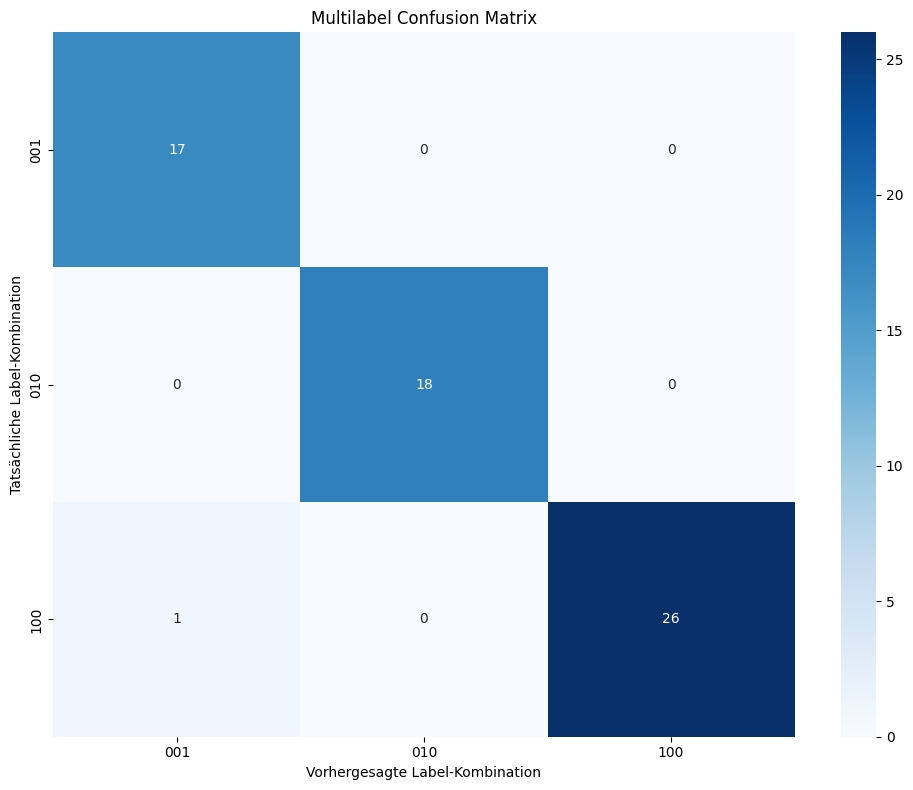

In [46]:
# Kombinierte Labels erzeugen
combined_y_test = y_test.apply(lambda row: ''.join(row.astype(str)), axis=1)
combined_y_pred = pd.DataFrame(y_pred, columns=y.columns).apply(lambda row: ''.join(row.astype(str)), axis=1)

# Confusion Matrix berechnen
conf_matrix_combined = confusion_matrix(combined_y_test, combined_y_pred)

# Labels sortieren
labels_sorted = sorted(set(combined_y_test) | set(combined_y_pred))

# Matrix plotten
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Vorhergesagte Label-Kombination")
plt.ylabel("Tatsächliche Label-Kombination")
plt.title("Multilabel Confusion Matrix")
plt.tight_layout()
plt.show()

In [83]:
y_pred = best_forest_model.predict(X)

In [48]:
report = classification_report(y_test, y_pred, target_names=y.columns, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df

,precision,recall,f1-score,support
label_cut-off,1.000000,0.962963,0.981132,27.0
label_multi,1.000000,1.000000,1.000000,18.0
label_single,0.944444,1.000000,0.971429,17.0
micro avg,0.983871,0.983871,0.983871,62.0
macro avg,0.981481,0.987654,0.984187,62.0
weighted avg,0.984767,0.983871,0.983949,62.0
samples avg,0.983871,0.983871,0.983871,62.0


In [ ]:
dump(best_forest_model, 'Models/complete_segmentation_identifier_random_forest.joblib')

['Models/complete_segmentation_identifier_random_forest.joblib']

In [ ]:
loaded_model = load('Models/complete_segmentation_identifier_random_forest.joblib')

In [45]:
y_pred = loaded_model.predict(X)

In [47]:
class_names = ['cut-off', 'single', 'multi', 'blurred']
y_pred_df = pd.DataFrame(y_pred, columns=class_names)
y_pred_df.index = df.index
df_pred = pd.concat([df, y_pred_df], axis=1)
df_pred.to_csv("Data/predicted_segmentation_data.csv", index=False)

In [ ]:
single_egg_df = df.loc[df[“single”] == 1].reset_index(drop=True)


multi_egg_image = []
multi_egg_mask = []
for i, image in enumerate(images):
    if df_pred.loc[i, 'single'] == 1:
        multi_egg_image.append(image)
        multi_egg_mask.append(masks[i])

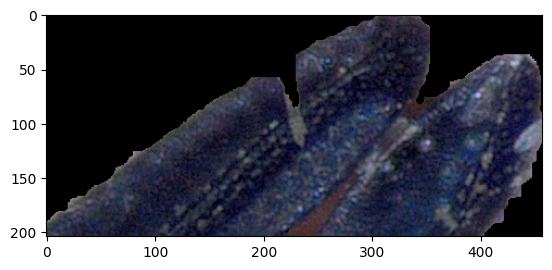

In [64]:
plt.imshow(multi_egg_image[1])